# Power Outage Length Analysis Based on Type of Cause

**Name(s)**: Claire Tu, Po-Hua Chen

**Website Link**: https://ctu-tls.github.io/power_outage_length_analysis/

In [22]:
import os
import numpy as np
import pandas as pd
from pathlib import Path
import plotly.express as px
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_absolute_error
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt

pd.options.plotting.backend = "plotly"

## Step 1: Introduction

### Power Outages

Power outages affect far more than just lights turning off. They interrupt daily routines, disrupt communication, pause business operations, and bring safety risks. Whether caused by extreme weather, equipment failures, or non-natural activity, outages impact millions of households each year and expose how dependent our modern lives are on stable electricity. As climate events intensify and energy demand increases, understanding when and why outages occur has become increasingly important. In this project, we analyze major power outages in the United States to uncover trends over time, compare different causes, and identify factors that influence outage length. By approaching the data systematically, we aim to highlight why outage patterns could matter for communities, policymakers, and anyone who relies on a reliable power system.

### Reason Behind Choosing the Dataset

We chose the Power Outages dataset because it is similar to projects we have worked on before, and power outage data is exciting. It will be easier to organize and interpret. 
We also has experianced power outages ourselves in the past weeks, therefore this analysis is highly related to our personal lives as well.
We excluded the other two datasets because the recipes contained too much textual data, and the League of Legends dataset involved gaming knowledge that was unfamiliar to me.

### Dataset Description
In this project, our data came from a Purdue University dataset that contained power outage data in the continental U.S. from January 2000 to July 2016. There are 1534 rows x 56 columns in total. Each row in the dataset represents an outage event and contains information on when and where the outage occurred, the cause, duration, and the number of users affected.

We will use these data to analyze the following question: Does the length of power outage differ on natural reasons or non-natural-caused reasons?

We will use the following columns in our analysis:

- `YEAR`: The year of the outage  
- `MONTH`: The month of the outage  
- `U.S._STATE`: The state of the outage  
- `NERC.REGION`: The geographical region assigned by the North American Electric Reliability Corporation (NERC)  
- `OUTAGE.START.DATE`: Date of the outage  
- `OUTAGE.START.TIME`: Time of the outage  
- `CLIMATE.REGION`: Climate region of the United States
- `OUTAGE.DURATION`: Duration of the outage in minutes
- `CAUSE.CATEGORY`: General cause of the outage

## Step 2: Data Cleaning and Exploratory Data Analysis

In [23]:
!pip install openpyxl

### Data Cleaning

The first few rows of the original data contain metadata for description rather than actual outage data, so we remove the initial non-data rows (`iloc[7:]`) and use the sixth row as the column names. We then delete the variables column if it exists. Finally, we convert `YEAR`, `MONTH`, `OUTAGE.DURATION`, `DEMAND.LOSS.MW`, and `CUSTOMERS.AFFECTED` to numeric values, and set values that cannot be converted to missing values (`NaN`) for subsequent statistical analysis and visualization.

In [24]:
outages = pd.read_excel("outage.xlsx", header=None)
outages.columns = outages.iloc[5]
outages = outages.iloc[7:].reset_index(drop=True)

if "variables" in outages.columns:
    outages = outages.drop(columns=["variables"])

numeric_cols = ["YEAR", "MONTH", "OUTAGE.DURATION", "DEMAND.LOSS.MW", "CUSTOMERS.AFFECTED"]

for col in numeric_cols:
    if col in outages.columns:
        outages[col] = pd.to_numeric(outages[col], errors="coerce")

outages.head()

5,OBS,YEAR,MONTH,U.S._STATE,POSTAL.CODE,NERC.REGION,CLIMATE.REGION,ANOMALY.LEVEL,CLIMATE.CATEGORY,OUTAGE.START.DATE,...,POPPCT_URBAN,POPPCT_UC,POPDEN_URBAN,POPDEN_UC,POPDEN_RURAL,AREAPCT_URBAN,AREAPCT_UC,PCT_LAND,PCT_WATER_TOT,PCT_WATER_INLAND
0,1,2011,7.0,Minnesota,MN,MRO,East North Central,-0.3,normal,2011-07-01 00:00:00,...,73.27,15.28,2279,1700.5,18.2,2.14,0.6,91.592666,8.407334,5.478743
1,2,2014,5.0,Minnesota,MN,MRO,East North Central,-0.1,normal,2014-05-11 00:00:00,...,73.27,15.28,2279,1700.5,18.2,2.14,0.6,91.592666,8.407334,5.478743
2,3,2010,10.0,Minnesota,MN,MRO,East North Central,-1.5,cold,2010-10-26 00:00:00,...,73.27,15.28,2279,1700.5,18.2,2.14,0.6,91.592666,8.407334,5.478743
3,4,2012,6.0,Minnesota,MN,MRO,East North Central,-0.1,normal,2012-06-19 00:00:00,...,73.27,15.28,2279,1700.5,18.2,2.14,0.6,91.592666,8.407334,5.478743
4,5,2015,7.0,Minnesota,MN,MRO,East North Central,1.2,warm,2015-07-18 00:00:00,...,73.27,15.28,2279,1700.5,18.2,2.14,0.6,91.592666,8.407334,5.478743


### Univariate Analysis

#### Distribution of outage durations

The histogram shows that the outage duration (in minutes) distribution is highly right-skewed. Most outages last for a relatively short time, but a few events last much longer, creating a long right tail. Because of these extreme values, the mean may be inflated, so the median is a more representative measure of outage duration.

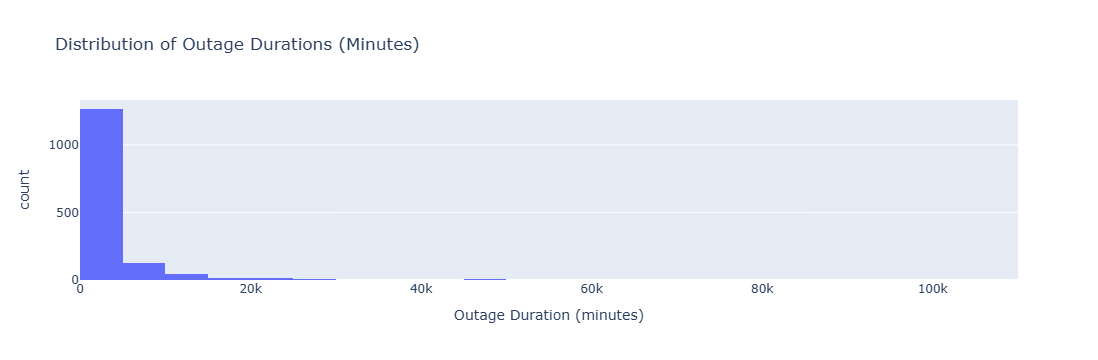

In [25]:
fig = px.histogram(
    outages.dropna(subset=["OUTAGE.DURATION"]),
    x="OUTAGE.DURATION",
    nbins=40,
    title="Distribution of Outage Durations (Minutes)",
    labels={"OUTAGE.DURATION": "Outage Duration (minutes)"}
)
fig.show()

In [26]:
# for saving the file
fig.write_html(
    "assets/univariate_outage_duration.html",
    include_plotlyjs="cdn",
    full_html=True
)

#### Distribution of cause categories

This bar chart shows the frequency of each type of outage, with severe weather being the most frequent, followed by non-natural-caused outages such as intentional attacks. Because weather-related events account for a large share of all outages, it is natural to compare the durations of natural and non-natural-caused outages in later sections.

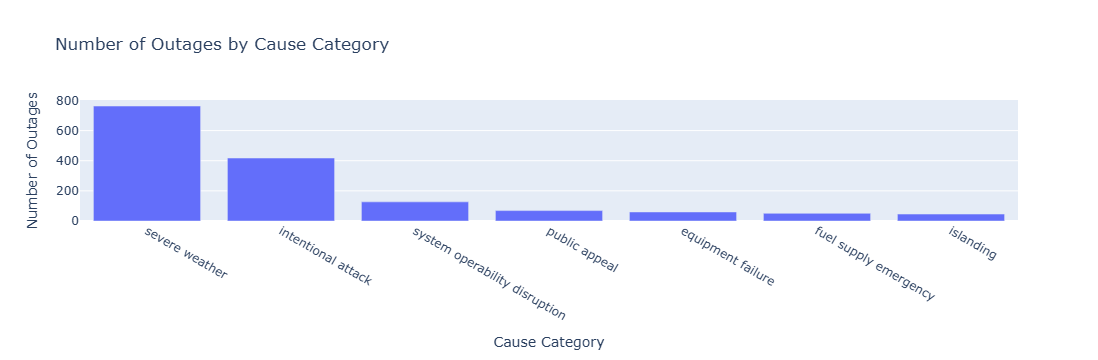

In [27]:
cause_counts = outages["CAUSE.CATEGORY"].value_counts().reset_index()
cause_counts.columns = ["CAUSE.CATEGORY", "count"]

fig = px.bar(
    cause_counts,
    x="CAUSE.CATEGORY",
    y="count",
    title="Number of Outages by Cause Category",
    labels={"CAUSE.CATEGORY": "Cause Category", "count": "Number of Outages"}
)
fig.show()

In [28]:
# for saving the file
fig.write_html(
    "assets/distribution_cause_category.html",
    include_plotlyjs="cdn",
    full_html=True
)

### Bivariate Analysis

#### Outage duration by cause category

This scatterplot shows the relationship between outage duration (in minutes) and the number of customers affected. Most outage events affect a small number of people and are relatively short; however, when the number of affected households is very large, the variation in outage duration becomes greater, with some events lasting a very long time. Overall, there is no clear linear relationship, but large outage events tend to be accompanied by longer or more erratic outage durations.

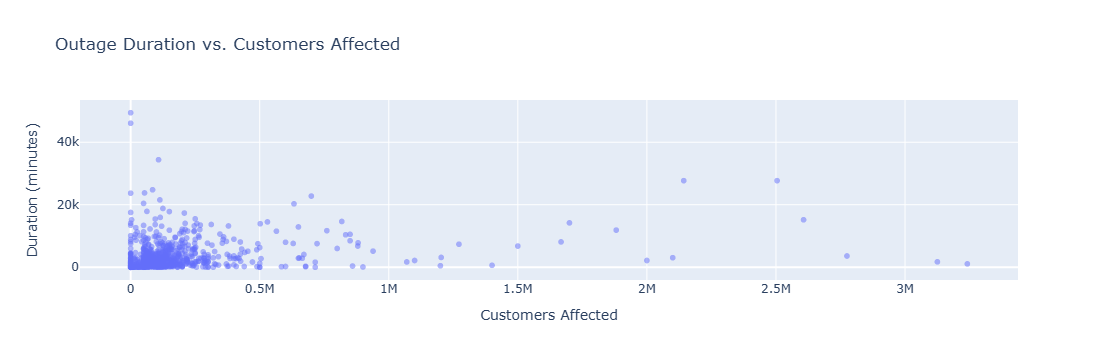

In [29]:
biv2 = outages.dropna(subset=["OUTAGE.DURATION", "CUSTOMERS.AFFECTED"])

fig = px.scatter(
    biv2,
    x="CUSTOMERS.AFFECTED",
    y="OUTAGE.DURATION",
    title="Outage Duration vs. Customers Affected",
    labels={"CUSTOMERS.AFFECTED": "Customers Affected", "OUTAGE.DURATION": "Duration (minutes)"},
    opacity=0.5
)
fig.show()

In [30]:
# for saving the file
fig.write_html(
    "assets/bivariate_customers_vs_duration.html",
    include_plotlyjs="cdn",
    full_html=True
)

### Interesting Aggregates

This pivot table shows the median duration of outages for each cause, sorted from largest to smallest. The results show that fuel supply emergency and severe weather have longer typical outages, while intentional attack has shorter outages, and the median avoids skewing the average.

In [31]:
pivot = outages.pivot_table(
    values="OUTAGE.DURATION",
    index="CAUSE.CATEGORY",
    aggfunc="median"
).sort_values("OUTAGE.DURATION", ascending=False)

pivot

5,OUTAGE.DURATION
CAUSE.CATEGORY,
fuel supply emergency,3960.0
severe weather,2460.0
public appeal,455.0
equipment failure,221.0
system operability disruption,215.0
islanding,77.5
intentional attack,56.0


## Step 3: Assessment of Missingness

### NMAR Analysis

We suspect `CUSTOMERS.AFFECTED` may be NMAR because small-scale outages that affect very few customers are less likely to be fully documented or may be omitted during data collection, making missingness more likely when the true number of affected customers is very small.

In the dataset, `CUSTOMERS.AFFECTED` is classified as NMAR (Not Missing At Random). When the number of people affected by a small outage is very small, it may be less likely to be fully documented or may be omitted. In other words, whether the data is missing may depend on the true but unobserved value of `CUSTOMERS.AFFECTED` itself, which is consistent with the definition and intuition of NMAR.

Observation of the data shows that `CUSTOMERS.AFFECTED` has a high missing rate, and the median of `OUTAGE.DURATION` is lower when the data is missing and higher when it is not, which is consistent with the idea that small-scale outages are more likely to be missed. However, NMAR cannot be statistically validated using observed data alone, and determining whether the missingness is truly NMAR would require the utility company’s internal reporting policies and omission thresholds.

### Missingness Dependency

We supposed that `OUTAGE.CATEGORY.DETAILS` are missing will be highly correlated to the category that it is belongs in, `OUTAGE.CATEGORY`. Therefore we run a permuation test to see if there is a significant correlation between the two. 

In [32]:
def tvd(p, q):
    idx = p.index.union(q.index)
    p = p.reindex(idx, fill_value=0)
    q = q.reindex(idx, fill_value=0)
    return 0.5 * np.abs(p - q).sum()

def stat_tvd_cat(col, missing):
    mask = col.notna()
    col = col[mask]
    missing = missing[mask]

    p = col[missing].value_counts(normalize=True)
    q = col[~missing].value_counts(normalize=True)
    return tvd(p, q)

def stat_diff_means_num(col, missing):
    col = pd.to_numeric(col, errors='coerce')
    mask = col.notna()
    col = col[mask]
    missing = missing[mask]
    return abs(col[missing].mean() - col[~missing].mean())

def perm_test(stat_func, y, missing, reps=10000, seed=42):
    rng = np.random.default_rng(seed)
    observed = stat_func(y, missing)
    miss_arr = missing.to_numpy()
    ge = 0
    stats = np.empty(reps)

    for i in range(reps):
        perm = rng.permutation(miss_arr)
        s = stat_func(y, pd.Series(perm, index=missing.index))
        stats[i] = s
        ge += (s >= observed)
    p_value = (ge + 1) / (reps + 1)
    return observed, p_value, stats

Test statistic (TVD) observed: 0.4107
p-value: 0.0001
With 𝛼 = 0.05, we reject H0
Therefore, the missingness of CAUSE.CATEGORY.DETAIL depends on CAUSE.CATEGORY (not MCAR relative to this column).

In [33]:
X = 'CAUSE.CATEGORY.DETAIL'
Y = 'CAUSE.CATEGORY'

x_missing = outages['CAUSE.CATEGORY.DETAIL'].isna()
x_missing.mean()

obs, p, stats = perm_test(stat_tvd_cat, outages[Y], x_missing, reps=10000, seed=42)
obs, p


(np.float64(0.41067323382726845), np.float64(9.999000099990002e-05))

We tested whether the missingness of `CAUSE.CATEGORY.DETAIL` depends on `ANOMALY.LEVEL`.
H0: The missingness of `CAUSE.CATEGORY.DETAIL` is independent of `ANOMALY.LEVEL`.
H1: The missingness depends on `ANOMALY.LEVEL`.
We used absolute difference in means of `ANOMALY.LEVEL` between rows where CAUSE.CATEGORY.DETAIL is missing vs not missing as the test statistic.
The observed statistic was 0.0105, and the permutation test yielded p = 0.794.
With  𝛼 = 0.05 , we fail to reject H0, so we do not find evidence that missingness depends on `ANOMALY.LEVEL`.

In [34]:
Z = 'ANOMALY.LEVEL'
obs, p, stats = perm_test(stat_diff_means_num, outages[Z], x_missing, reps=10000, seed=42)
obs, p

(np.float64(0.010520318644751447), np.float64(0.794020597940206))

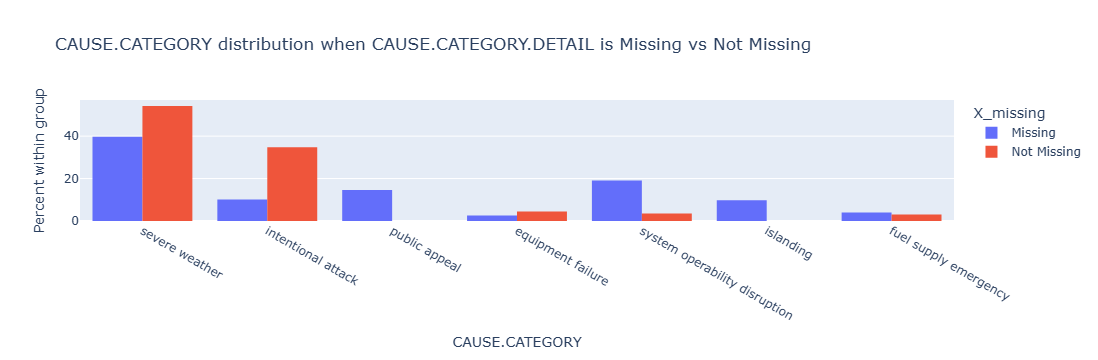

In [35]:
tmp = outages[[X, Y]].copy()
tmp['X_missing'] = tmp[X].isna().map({True: 'Missing', False: 'Not Missing'})
tmp = tmp.dropna(subset=[Y])

fig = px.histogram(
    tmp,
    x=Y,
    color='X_missing',
    barmode='group',
    histnorm='percent',
    title=f"{Y} distribution when {X} is Missing vs Not Missing"
)
fig.update_layout(xaxis_title=Y, yaxis_title="Percent within group")
fig.show()

os.makedirs("assets", exist_ok=True)
fig.write_html("assets/missingness_dep_on_cause_category.html", include_plotlyjs="cdn")


## Step 4: Hypothesis Testing

`Hypothesis`: Does the length of power outage differ on severe weather or non-natural weather outages?

`H0`: There **is no difference** between the outage length between severe weather or non-natural weather outages

`H1`: There **is a difference** between outage length of severe weather or non-natural weather outages

`Test statistic`: Average outage length (outage end time - outage start time)

In [53]:
clean = outages.dropna(subset=['OUTAGE.DURATION', 'CAUSE.CATEGORY']).copy()

def cause_type(category):
    if category == 'severe weather':
        return 'natural'
    else:
        return 'non_natural'

clean = clean.assign(cause_type = clean['CAUSE.CATEGORY'].apply(cause_type))
natural = clean.loc[clean['cause_type'] == 'natural', 'OUTAGE.DURATION']
non_natural   = clean.loc[clean['cause_type'] == 'non_natural', 'OUTAGE.DURATION']

obs_diff = natural.mean() - non_natural.mean()
obs_diff

np.float64(2537.8062533051298)

In [54]:
def one_perm_diff(df):

    shuffled = (
        df['cause_type']
        .sample(frac=1, replace=False)
        .reset_index(drop=True)
    )
    
    values = df['OUTAGE.DURATION'].reset_index(drop=True)
    

    temp = pd.DataFrame({
        'cause_type': shuffled,
        'OUTAGE.DURATION': values
    })
    
    natural_mean = temp.loc[temp['cause_type'] == 'natural', 'OUTAGE.DURATION'].mean()
    non_natural_mean   = temp.loc[temp['cause_type'] == 'non_natural', 'OUTAGE.DURATION'].mean()
    
    return natural_mean - non_natural_mean

one_perm_diff(clean)

np.float64(210.89906134320472)

In [55]:
reps = 5000
diffs = []

for _ in range(reps):
    diffs.append(one_perm_diff(clean))

diffs = np.array(diffs)
extreme = np.sum(np.abs(diffs) >= abs(obs_diff))
#np.mean(np.abs(diffs) >= abs(obs_diff))

p_value = (extreme + 1) / (reps + 1)
p_value

np.float64(0.0001999600079984003)

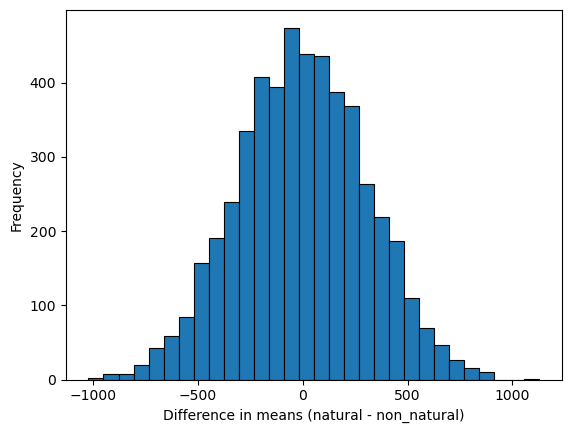

In [56]:
plt.hist(diffs, bins=30, edgecolor="black", linewidth=0.8) 
plt.xlabel("Difference in means (natural - non_natural)")
plt.ylabel("Frequency")
plt.show()

We tested H0: there is no difference between the outage length between non-natural-caused or natural-caused outages, and H1: there is a difference between the outage length of non-natural-caused and natural caused outages. 

The test results show that natural-caused outages lasted 2,538 minutes longer than non-natural-caused outages. I used a permutation test with 500,000 repetitions and obtained the p-value = 0.00000199 (<0.00001). Because the p-value is very small, I reject the null hypothesis. This leads to the conclusion that outages caused by natural causes have a significantly longer duration than those caused by non-natural factors.

## Step 5: Framing a Prediction Problem

The project formulated the prediction problem as a regression problem, with the goal of predicting the `OUTAGE.DURATION` (minutes) for each outage. Outage duration is a continuous value, so a classification model is not appropriate, and a regression model is used to predict it instead. The model uses information known at the time of the outage as features, including `CUSTOMERS.AFFECTED` and `CAUSE.CATEGORY` as model inputs. 

To evaluate the model's predictive performance, mean absolute error (MAE) is used as a metric. MAE is less sensitive to the extremes of long outages than squared-error-based metrics, and better reflects the model's predictive performance for general outage events.

## Step 6: Baseline Model

In [15]:
data = outages[["CUSTOMERS.AFFECTED", "CAUSE.CATEGORY", "OUTAGE.DURATION"]].dropna()
X = data[["CUSTOMERS.AFFECTED", "CAUSE.CATEGORY"]]
y = data["OUTAGE.DURATION"]

preprocessor = ColumnTransformer(transformers=[("num", "passthrough", ["CUSTOMERS.AFFECTED"]),("cat", OneHotEncoder(handle_unknown="ignore"), ["CAUSE.CATEGORY"])])

model = Pipeline(steps=[("preprocessor", preprocessor), ("regressor", LinearRegression())])

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', 'passthrough',
                                                  ['CUSTOMERS.AFFECTED']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['CAUSE.CATEGORY'])])),
                ('regressor', LinearRegression())])

In [17]:
y_pred = model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
mae

np.float64(2472.2685838900047)

## Step 7: Final Model

Our final model used regularized linear regression (Ridge) model implemented as a single scikit-learn Pipeline. Compared to the baseline, we expanded the feature set and added multiple feature engineering steps to better capture patterns that influence outage duration while reducing overfitting from high-dimensional one-hot encoded features.

We also added more features on predicting, including `CAUSE.CATEGORY.DETAIL`, `CLIMATE.REGION`, `NERC.REGION`, `U.S._STATE`, `ANOMALY.LEVEL`, `YEAR` and `MONTH`. We added them to take into more geolgical and time related data for better predictions. 





In [18]:
outages['OUTAGE.DURATION'] = pd.to_numeric(outages['OUTAGE.DURATION'], errors='coerce')
df_model = outages.dropna(subset=['OUTAGE.DURATION']).copy()

features = [
    'CUSTOMERS.AFFECTED',
    'CAUSE.CATEGORY',
    'CAUSE.CATEGORY.DETAIL',
    'CLIMATE.REGION',
    'NERC.REGION',
    'U.S._STATE',
    'ANOMALY.LEVEL',
    'YEAR',
    'MONTH',
    'OUTAGE.START.DATE',
    'OUTAGE.START.TIME'
]

'''
another set of feature choices could be:
df = outages[["YEAR", "MONTH", "U.S._STATE", "NERC.REGION", "OUTAGE.START.DATE", 
               "OUTAGE.START.TIME", "CLIMATE.REGION", "OUTAGE.DURATION", 
               "CAUSE.CATEGORY"]].copy()
df
'''

X = df_model[features].copy()
y = df_model['OUTAGE.DURATION']

We also engineered new features:

`LOG_CUSTOMERS_AFFECTED` = log1p(CUSTOMERS.AFFECTED) to reduce skew and prevent extremely large outages from dominating the linear fit.

`Season/time` features derived from the outage start time (e.g., season from month, start hour, day of week) to capture systematic differences in outage duration by timing.

Missingness indicators + imputation for numeric columns so the model can learn patterns related to missing values instead of silently dropping rows.

In [19]:
class FeatureEngineer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        X = X.copy()

        for c in ['CUSTOMERS.AFFECTED', 'ANOMALY.LEVEL', 'YEAR', 'MONTH']:
            if c in X.columns:
                X[c] = pd.to_numeric(X[c], errors='coerce')

        X['LOG_CUSTOMERS_AFFECTED'] = np.log1p(X['CUSTOMERS.AFFECTED'])

        def month_to_season(m):
            if pd.isna(m): return np.nan
            m = int(m)
            if m in (12, 1, 2): return 'Winter'
            if m in (3, 4, 5): return 'Spring'
            if m in (6, 7, 8): return 'Summer'
            return 'Fall'
        X['SEASON'] = X['MONTH'].apply(month_to_season)

        if 'OUTAGE.START.TIME' in X.columns:
            def get_hour(t):
                if pd.isna(t): return np.nan
                try:
                    return int(getattr(t, 'hour', pd.to_datetime(str(t)).hour))
                except Exception:
                    return np.nan
            X['START_HOUR'] = X['OUTAGE.START.TIME'].apply(get_hour)

        if 'OUTAGE.START.DATE' in X.columns:
            dt = pd.to_datetime(X['OUTAGE.START.DATE'], errors='coerce')
            X['START_DOW'] = dt.dt.day_name()

        return X

Because the expanded feature set produces many one-hot encoded columns, the model becomes high-dimensional. We chose Ridge regression since L2 regularization stabilizes coefficients and helps prevent overfitting. We performed hyperparameter tuning using GridSearchCV over alpha (regularization strength) and selected the model with the best cross-validated MAE.

In [24]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

num_cols = [
    'CUSTOMERS.AFFECTED',
    'LOG_CUSTOMERS_AFFECTED',
    'ANOMALY.LEVEL',
    'YEAR',
    'MONTH',
    'START_HOUR'
]
cat_cols = [
    'CAUSE.CATEGORY',
    'CAUSE.CATEGORY.DETAIL',
    'CLIMATE.REGION',
    'NERC.REGION',
    'U.S._STATE',
    'SEASON',
    'START_DOW'
]

num_pipe = Pipeline([
    ('imp', SimpleImputer(strategy='median', add_indicator=True)),  # (extra FE: missing indicators)
    ('scaler', StandardScaler())
])

cat_pipe = Pipeline([
    ('imp', SimpleImputer(strategy='constant', fill_value='Missing')),
    ('ohe', OneHotEncoder(handle_unknown='ignore'))
])

pre = ColumnTransformer([
    ('num', num_pipe, num_cols),
    ('cat', cat_pipe, cat_cols)
])

final_pipe = Pipeline([
    ('fe', FeatureEngineer()),
    ('pre', pre),
    ('model', Ridge(random_state=42))
])

param_grid = {
    'model__alpha': [0.1, 1, 10, 100, 300],
    'model__fit_intercept': [True, False]
}

grid = GridSearchCV(
    final_pipe,
    param_grid=param_grid,
    scoring='neg_mean_absolute_error',
    cv=3,
    n_jobs=1
)

grid.fit(X_train, y_train)

best_model = grid.best_estimator_
pred = best_model.predict(X_test)

final_mae = mean_absolute_error(y_test, pred)
grid.best_params_, final_mae

({'model__alpha': 300, 'model__fit_intercept': False},
 np.float64(2440.2767227356235))

## Step 8: Fairness Analysis

In [ ]:
# TODO